The environment used to build the project:

* Python 3.7.0

* Windows 10

In [13]:
# The libraries imported for the project code:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier



In [14]:
# test, train and validation data

# read train data that was cleaned, missing values knn imputed, outliers removed and z-score normalized.

xtrain = pd.read_csv("x_train.csv")
ytrain = pd.read_csv("y_train.csv")

xtrain=xtrain.iloc[:,1:]
ytrain=ytrain.iloc[:,1:]
print("TRAINING DATA")
print(xtrain.shape)
print(ytrain.shape)
print()



TRAINING DATA
(40000, 107)
(40000, 1)



Imbalanced classes - so F1 better than accuracy.

precison and recall also useful

In [15]:
print ("UNBALANCED DATASET: " )
#20%-80%
print(ytrain["y"].value_counts())
print()

x_train, x_val, y_train, y_val = train_test_split( xtrain, ytrain, test_size=0.2, random_state=42)
print ("TRAIN: ", x_train.shape)
print ("VAL: " , x_val.shape)

x_test = pd.read_csv("processed_test.csv")
x_test = x_test.iloc[:,1:]
print("TEST: ",x_test.shape)

print ("VALIDATION: ", y_val["y"].value_counts())
print ("TRAINING: " , y_train["y"].value_counts())

UNBALANCED DATASET: 
0    31880
1     8120
Name: y, dtype: int64

TRAIN:  (32000, 107)
VAL:  (8000, 107)
TEST:  (10000, 107)
VALIDATION:  0    6380
1    1620
Name: y, dtype: int64
TRAINING:  0    25500
1     6500
Name: y, dtype: int64


In [4]:
# OVERSAMPLING

from imblearn.over_sampling import SMOTE
ros = SMOTE(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x_train.to_numpy(), y_train.to_numpy())
from collections import Counter
print(sorted(Counter(y_resampled).items()))



[(0, 25500), (1, 25500)]


In [5]:
x_train_resampled = pd.DataFrame(X_resampled, columns = x_train.columns)
y_train_resampled = pd.DataFrame(y_resampled, columns = y_train.columns)

In [4]:
# Evaluation metrics

def metrics(y_true, y_score):
    print("################################################################################################")
    print("Evaluation metrics for data")
    y_true=y_true.to_numpy()
    y_score=y_score.to_numpy()
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # True negative
    tn = np.sum((y_true==0) * (y_score==0))
    # False negative
    fn = np.sum(y_true * (y_score==0))
    
    # tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()

    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # False positive rate (fall-out)
    fpr = fp / (fp + tn)
    # Precision
    precision = tp / (tp + fp)
    # True negatvie tate (specificity)
    tnr = 1 - fpr
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
    # ROC-AUC for binary classification
    #auc = (tpr+tnr) / 2
    # MCC
    #mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    print("True positive: ", tp)
    print()
    print("False positive: ", fp)
    print()
    print("True negative: ", tn)
    print()
    print("False negative: ", fn)
    print()
    print()
    print("True positive rate (recall): ", tpr)
    print()
    print("False positive rate: ", fpr)
    print()
    print("Precision: ", precision)
    print()
    print("True negative rate: ", tnr)
    print()
    print("F1: ", f1)
    print("################################################################################################")
    #print("ROC-AUC: ", auc)
    #print()
    #print("MCC: ", mcc)

In [5]:

def roc_auc_fn(y_true, pred_prob):
    y_true=y_true.to_numpy()
    fpr, tpr, _ = roc_curve(y_true, pred_prob)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', label='Model output')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    print("ROC-AUC Score:", roc_auc_score(y_true, pred_prob))

#print(roc_auc_fn(y_train, y_pred))

In [6]:
from sklearn.externals.joblib import parallel_backend

def grid_search_cv(estimator_model=SVC(), tuned_parameters={}):
    
    print ("ESTIMATOR: ", estimator_model)
    print("TUNED PARAMETERS: ", tuned_parameters)
    
    # Grid Search & 10 fold cross validation

    # Set the parameters by cross-validation
    

    scores = ['roc_auc', 'precision_macro', 'recall_macro']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            estimator_model, tuned_parameters, scoring='%s' % score, cv=10,n_jobs=1 
        )
        
        with parallel_backend('threading'):
            clf.fit(x_train, y_train)
        #clf.fit(x_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_val, clf.predict(x_val)
        print(classification_report(y_true, y_pred))
        print()
        

In [7]:
def run_evaluation_val(y_pred_val, pred_prob_val,chosen_classifier, x_val,y_val):
    metrics(y_val, y_pred_val)
    roc_auc_fn(y_val, pred_prob_val)
    disp = plot_precision_recall_curve(chosen_classifier, x_val, y_val)
    disp.ax_.set_title('2-class Precision-Recall curve')
    plot_confusion_matrix(chosen_classifier, x_val.to_numpy(), y_val.to_numpy())

In [ ]:
# GRID SEARCH ON NEURAL NETWROK

tuned_parameters= {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 'activation': ['tanh', 'relu'],
                   'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.05],'learning_rate': ['constant','adaptive'],}

estimator_model = MLPClassifier()
grid_search_cv(estimator_model=estimator_model, tuned_parameters=tuned_parameters)


ESTIMATOR:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
TUNED PARAMETERS:  {'alpha': [0.0001, 0.05, 0.1, 1e-06], 'learning_rate': ['constant']}
# Tuning hyper-parameters for roc_auc



NEURAL NETWORK:
0.99990625
################################################################################################
Evaluation metrics for data
True positive:  1523

False positive:  41

True negative:  6339

False negative:  97


True positive rate (recall):  0.9401234567901234

False positive rate:  0.006426332288401254

Precision:  0.9737851662404092

True negative rate:  0.9935736677115987

F1:  0.9566582914572864
################################################################################################


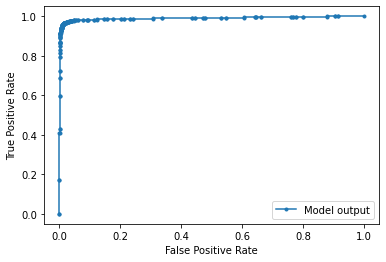

ROC-AUC Score: 0.9901288749564613
[0 1]


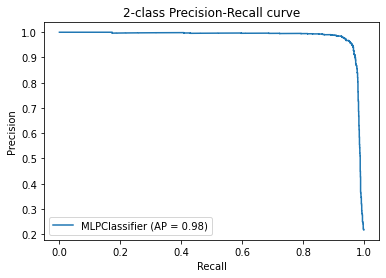

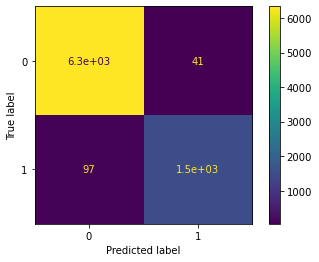

In [16]:
# MODEL CHOSEN BASED ON GRID SEARCH

print("NEURAL NETWORK:")

model = MLPClassifier(hidden_layer_sizes=(100,),
                      activation='relu', solver='adam', 
                   alpha=0.01, learning_rate="constant")
model = model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), columns=["y_pred"])
print(model.score(x_train, y_train))

y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred_val"])
probs_val = model.predict_proba(x_val)
chosen_classifier= model
## since binary- only prob of positive outcome
probs_val = probs_val[:, 1]
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)


#Test data
y_pred_test = pd.DataFrame(model.predict(x_test), columns=["y_pred_val"])
probs_test = model.predict_proba(x_test)
probs_test = probs_test[:, 1]
print (model.classes_)
np.savetxt("results1.csv",probs_test, delimiter=",")
#probs_test.to_csv("results1.csv", index=False, header=False)

NEURAL NETWORK:
1.0
################################################################################################
Evaluation metrics for data
True positive:  1540

False positive:  42

True negative:  6338

False negative:  80


True positive rate (recall):  0.9506172839506173

False positive rate:  0.0065830721003134795

Precision:  0.9734513274336283

True negative rate:  0.9934169278996865

F1:  0.9618988132417239
################################################################################################


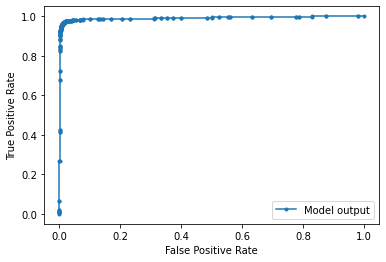

ROC-AUC Score: 0.9913484461472967


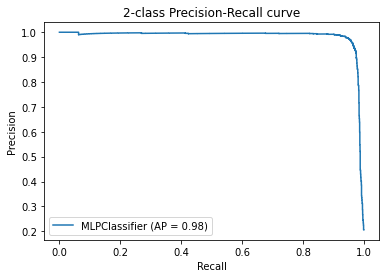

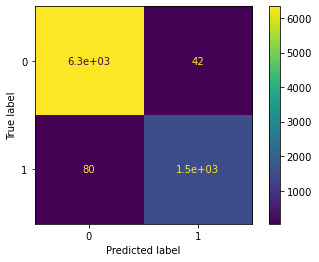

In [12]:
# BASE NN MODEL

print("NEURAL NETWORK:")

model = MLPClassifier()
model = model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), columns=["y_pred"])
print(model.score(x_train, y_train))

y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred_val"])
probs_val = model.predict_proba(x_val)
chosen_classifier= model
## since binary- only prob of positive outcome
probs_val = probs_val[:, 1]
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)



In [ ]:
# Support Vector Classifier Grid search and 10-fold stratified cross validation

tuned_parameters = {'kernel': ['rbf'], 'gamma': ["scale", "auto",0.0001],
                         'C': [1, 100]}

estimator_model=SVC()

grid_search_cv(estimator_model, tuned_parameters)

ESTIMATOR:  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
TUNED PARAMETERS:  [{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
# Tuning hyper-parameters for roc_auc



SVC:
0.99378125
################################################################################################
Evaluation metrics for data
True positive:  1536

False positive:  15

True negative:  6365

False negative:  84


True positive rate (recall):  0.9481481481481482

False positive rate:  0.0023510971786833857

Precision:  0.9903288201160542

True negative rate:  0.9976489028213166

F1:  0.9687795648060549
################################################################################################


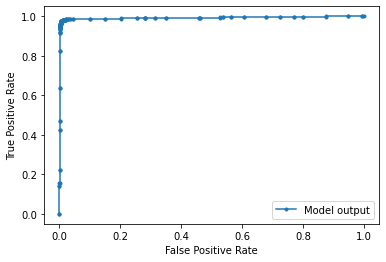

ROC-AUC Score: 0.9923733503618561
[0 1]


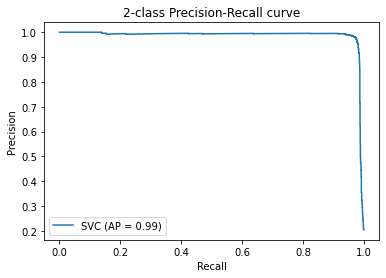

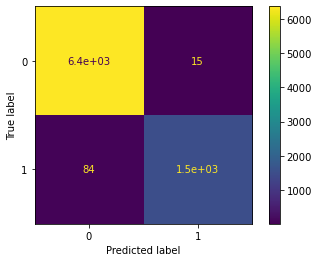

In [17]:
# MODEL CHOSEN BASED ON GRID SEARCH

print("SVC:")

model = SVC(kernel ="rbf", C=1.0, probability=True)
model = model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), columns=["y_pred"])
print(model.score(x_train, y_train))

y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred_val"])
probs_val = model.decision_function(x_val)
chosen_classifier= model
## since binary- only prob of positive outcome
#probs_val = probs_val[:, 1]
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)

#Test data
y_pred_test = pd.DataFrame(model.predict(x_test), columns=["y_pred_val"])
probs_test = model.predict_proba(x_test)
probs_test = probs_test[:, 1]
print (model.classes_)
#probs_test.to_csv("results2.csv", index=False, header=False)
np.savetxt("results2.csv",probs_test, delimiter=",")

Model Score: 0.89271875
################################################################################################
Evaluation metrics for data
True positive:  1001

False positive:  268

True negative:  6112

False negative:  619


True positive rate (recall):  0.6179012345679012

False positive rate:  0.04200626959247649

Precision:  0.7888100866824271

True negative rate:  0.9579937304075236

F1:  0.6929733471789546
################################################################################################


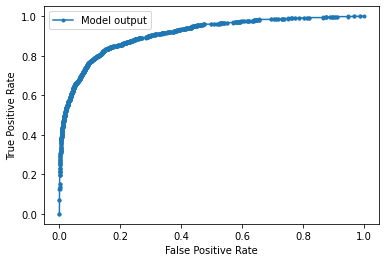

ROC-AUC Score: 0.9108203684353109


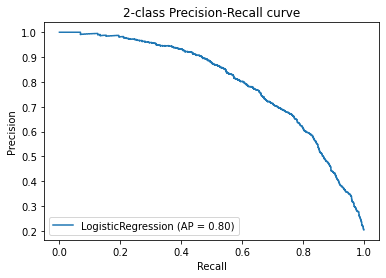

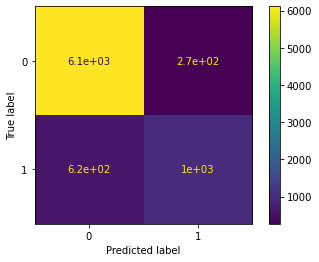

In [10]:
# LOGISTIC REGRESSION ON ORIGINAL DATA

model = LogisticRegression(random_state=10).fit(x_train, y_train)
y_pred_train = pd.DataFrame(model.predict(x_train), columns=["y_pred"])
y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred"])
print("Model Score:", model.score(x_train, y_train))
chosen_classifier= model
## keep probabilities for the  outcome = "1" - positive
probs_val = model.predict_proba(x_val)
probs_val = probs_val[:, 1]
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)


Model Score: 0.8498627450980392
################################################################################################
Evaluation metrics for data
True positive:  1354

False positive:  994

True negative:  5386

False negative:  266


True positive rate (recall):  0.8358024691358025

False positive rate:  0.15579937304075236

Precision:  0.5766609880749574

True negative rate:  0.8442006269592477

F1:  0.6824596774193549
################################################################################################


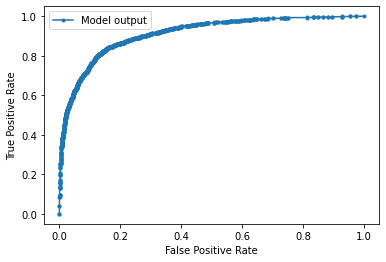

ROC-AUC Score: 0.91219706644994


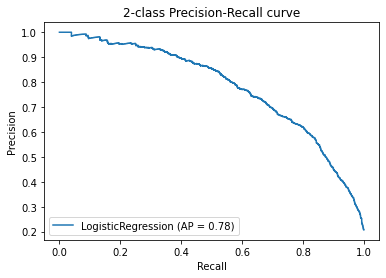

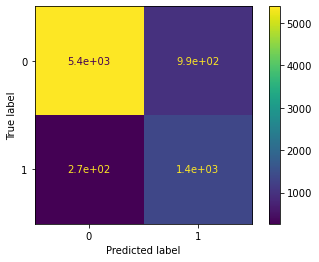

In [31]:
# LOGISTIC REGRESSION ON OVERSAMPLED DATA

model = LogisticRegression(random_state=10).fit(x_train_resampled, y_train_resampled)
y_pred_train = pd.DataFrame(model.predict(x_train_resampled), columns=["y_pred"])
y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred"])
print("Model Score:", model.score(x_train_resampled, y_train_resampled))
chosen_classifier= model

## keep probabilities for the  outcome = "1" - positive

probs_val = model.predict_proba(x_val)
probs_val = probs_val[:, 1]
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)


Model Score: 0.89153125

################################################################################################
Evaluation metrics for data
True positive:  880

False positive:  121

True negative:  6259

False negative:  740


True positive rate (recall):  0.5432098765432098

False positive rate:  0.01896551724137931

Precision:  0.8791208791208791

True negative rate:  0.9810344827586207

F1:  0.6714994276993514
################################################################################################


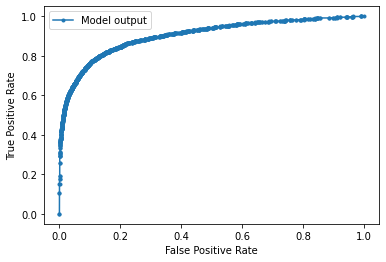

ROC-AUC Score: 0.9031677890011224


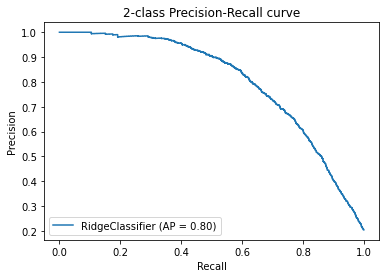

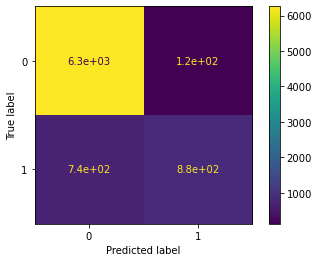

In [33]:
# RIDGE REGRESSION -NORMAL DATA WITHOUT OVERSAMPLING

# scores similar to Logistic regression
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier(random_state=10).fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), columns=["y_pred"])
y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred"])
print("Model Score:", model.score(x_train, y_train))
print()
chosen_classifier= model
## since binary- only prob of positive outcome
# probs = probs[:, 1]
probs_val = model.decision_function(x_val)
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)



Model Score: 0.8500588235294118

################################################################################################
Evaluation metrics for data
True positive:  1355

False positive:  1011

True negative:  5369

False negative:  265


True positive rate (recall):  0.8364197530864198

False positive rate:  0.15846394984326018

Precision:  0.5726965342349958

True negative rate:  0.8415360501567398

F1:  0.6798795785248369
################################################################################################


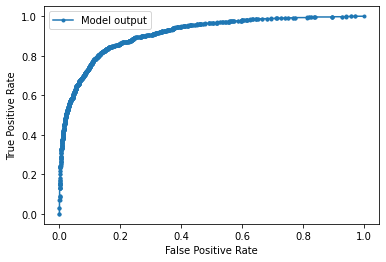

ROC-AUC Score: 0.9118592050775958


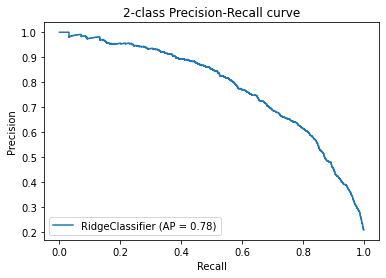

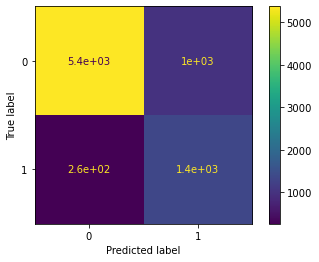

In [34]:
# RIDGE REGRESSION - DATA WITH SMOTE OVERSAMPLING

# scores similar to Logistic regression
from sklearn.linear_model import RidgeClassifier

model = RidgeClassifier(random_state=10).fit(x_train_resampled, y_train_resampled)
y_pred = pd.DataFrame(model.predict(x_train_resampled), columns=["y_pred"])
y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred"])
print("Model Score:", model.score(x_train_resampled, y_train_resampled))
print()
chosen_classifier= model
## since binary- only prob of positive outcome
# probs = probs[:, 1]
probs_val = model.decision_function(x_val)
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)



In [40]:
# RANDOM FOREST GRID SEARCH AND CROSS VALIDATION

# RFC gave 0.995969900983367 AUC for validation data with random state 10 and max_depth 10.

# GRID SEARCH 

print ("RANDOM FOREST")
tuned_parameters= {"n_estimators":[5,20,50,100],"max_features":['auto'], "max_depth":[10,None,100], 
                   "min_samples_leaf":[1], "bootstrap":[True,False]}

estimator_model=RandomForestClassifier(random_state=10)
grid_search_cv(estimator_model=estimator_model, tuned_parameters=tuned_parameters)



RANDOM FOREST
ESTIMATOR:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)
TUNED PARAMETERS:  {'n_estimators': [5, 30, 50, 100], 'max_features': ['auto'], 'max_depth': [10, None, 100], 'min_samples_leaf': [1], 'bootstrap': [True]}
# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}

Grid scores on development set:

0.879 (+/-0.012) for {'bootstrap': True, 'max_

1.0
################################################################################################
Evaluation metrics for data
True positive:  809

False positive:  4

True negative:  6376

False negative:  811


True positive rate (recall):  0.4993827160493827

False positive rate:  0.0006269592476489029

Precision:  0.995079950799508

True negative rate:  0.9993730407523511

F1:  0.6650226058364159
################################################################################################


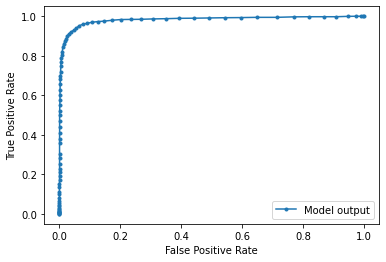

ROC-AUC Score: 0.9825166415108942


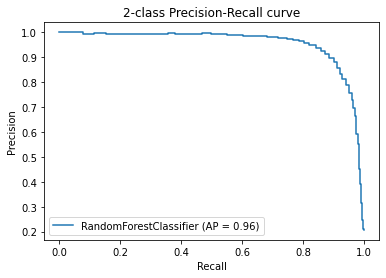

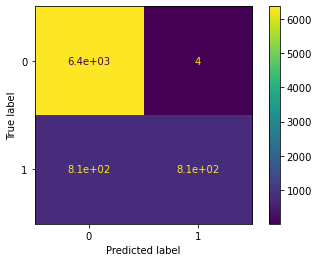

In [63]:
# Chosen RF model from grid search

model = RandomForestClassifier(random_state=10,  n_estimators =100, max_features='auto', max_depth=None, 
                   min_samples_leaf=1, bootstrap=False)

model = model.fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), columns=["y_pred"])
print(model.score(x_train, y_train))

y_pred_val = pd.DataFrame(model.predict(x_val), columns=["y_pred_val"])
probs_val = model.predict_proba(x_val)
chosen_classifier= model
## since binary- only prob of positive outcome
probs_val = probs_val[:, 1]
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)



################################################################################################
Evaluation metrics for data
True positive:  1073

False positive:  745

True negative:  5635

False negative:  547


True positive rate (recall):  0.6623456790123456

False positive rate:  0.11677115987460815

Precision:  0.5902090209020903

True negative rate:  0.8832288401253918

F1:  0.6242001163467132
################################################################################################


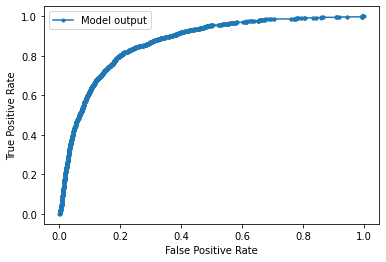

ROC-AUC Score: 0.8690512887495645
Number of mislabeled points out of a total 8000 points : 1292


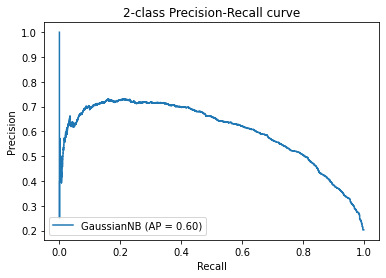

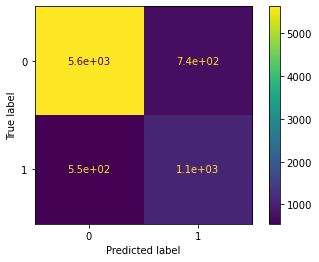

In [35]:
# Gaussian Naive Bayes on not-oversampled data - not competitive results so not considered forward.

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model = gnb.fit(x_train, y_train)
y_pred_train = pd.DataFrame(model.predict(x_train), columns =["y"])
y_pred_val = pd.DataFrame(model.predict(x_val), columns =["y"])
chosen_classifier = model

probs_val = model.predict_proba(x_val)
probs_val = probs_val[:, 1]
run_evaluation_val(y_pred_val, probs_val,chosen_classifier, x_val,y_val)
print("Number of mislabeled points out of a total %d points : %d" % (x_val.shape[0], (y_val.to_numpy() != y_pred_val.to_numpy()).sum()))

# BAD RESULTS FOR VALIDATION:
# low precision!! recall also not great!
# True positive:  1073
# False positive:  745
# True negative:  5635
# False negative:  547
# True positive rate (recall):  0.6623456790123456
# False positive rate:  0.11677115987460815
# Precision:  0.5902090209020903
# True negative rate:  0.8832288401253918
# F1:  0.6242001163467132

(40000, 100)
          x0         x1        x2         x3         x4         x5        x6  \
0 -17.933519   6.559220  2.422468 -27.737392 -12.080601  -3.892934  1.067466   
1 -37.214754  10.774930  5.404072  21.354738   0.612690  -3.093533  6.161558   
2   0.330441 -19.609972 -1.331804 -15.153892  19.710240  19.077300 -1.747110   
3 -13.709765  -8.011390 -1.536483  23.129497  27.880879  20.573991 -1.617689   
4  -4.202598   7.076210  8.881550  23.600777  26.232164 -14.462320  3.231193   

         x7         x8        x9  ...        x90        x91        x92  x93  \
0  0.935953  10.912007  1.107144  ... -94.582358  11.107047   0.093337  0.0   
1 -0.972156  -5.222169  0.384969  ...   1.474587  -1.991846  15.666187  0.0   
2  0.545570  -1.464609  3.670570  ...   5.160726  17.132840  -5.333012  0.0   
3  4.129694   1.139928  2.912838  ... -26.589765  12.292136   4.177925  0.0   
4 -0.069364  -7.310536 -2.268700  ...  61.178243   6.218743   8.715709  0.0   

        x94        x95        x

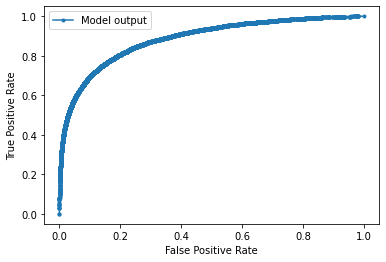

0.8852831894233919


In [143]:
# ROUGH CODE - BASE MODEL

# BARE MINIMUM PREPROCESSING AND LOGISTIC REGRESSION - BASELINE MODEL
# 0.86 score & 0.8839 AUC with one-hot and 0.8852 with label encoding

# x_data is the training data without applying outliers detection

x_data = pd.read_csv("categorical_x_train.csv")
y_train = pd.read_csv("y_train.csv")
y_train =y_train.iloc[:,1:]
imputer = KNNImputer(n_neighbors=100)
x_data = x_data.iloc[:,1:]

print(x_data.shape)
# print(x_data['x35'].value_counts())

days={"fri": "friday","thur":"thursday","wed":"wednesday","thurday":"thursday"}
months = {"Dev":"Dec","sept.":"Sep","January":"Jan","July":"Jul"}
x_data = x_data.replace({"x35": days})
x_data = x_data.replace({"x68":months})

'''

# One Hot encoding
x_data['x34'] = x_data['x34'].fillna(x_data['x34'].mode().iloc[0])
x_data['x35'] = x_data['x35'].fillna(x_data['x35'].mode().iloc[0])
x_data['x68'] = x_data['x68'].fillna(x_data['x68'].mode().iloc[0])
x_data['x93'] = x_data['x93'].fillna(x_data['x93'].mode().iloc[0])
onehotencoder = OneHotEncoder(sparse=False)
x_data = pd.concat((x_data,pd.DataFrame(onehotencoder.fit_transform(x_data['x34'].values.reshape(-1,1)))),1)
x_data = pd.concat((x_data,pd.DataFrame(onehotencoder.fit_transform(x_data['x35'].values.reshape(-1,1)))),1)
x_data = pd.concat((x_data,pd.DataFrame(onehotencoder.fit_transform(x_data['x68'].values.reshape(-1,1)))),1)
x_data = pd.concat((x_data,pd.DataFrame(onehotencoder.fit_transform(x_data['x93'].values.reshape(-1,1)))),1)
x_data=x_data.drop(['x34','x35','x68','x93'], axis=1)'''

X_train_capped=x_data

# Label Encoding used instead of one-hot encoding 
# Manually instead of  using sklearn LabelEncoder as data is less
car_names_list = list(set(X_train_capped["x34"].tolist()))
car_names_mapping = {k: v for v, k in enumerate(car_names_list)}
day_list = list(set(X_train_capped["x35"].tolist()))
day_mapping = {k: v for v, k in enumerate(day_list)}
#print ("day_mapping : ", day_mapping)
months_list = list(set(X_train_capped["x68"].tolist())) 
months_mapping = {k: v for v, k in enumerate(months_list)}
#print ("months_mapping : ",months_mapping)
continents_list = list(set(X_train_capped["x93"].tolist())) 
continents_mapping = {k: v for v, k in enumerate(continents_list)}
#print ("continents_mapping : ",continents_mapping)
X_train_capped = X_train_capped.replace({"x34":car_names_mapping})
X_train_capped = X_train_capped.replace({"x35":day_mapping})
X_train_capped = X_train_capped.replace({"x68":months_mapping})
X_train_capped = X_train_capped.replace({"x93":continents_mapping})
# Label encoding finished

x_data=X_train_capped

# Percentage sign in x45 column and $ sign in x41
def clean_cost(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

# print ("Nulls in price column:", X_train_capped["x41"].isna().sum())
x_data['x45'] = x_data['x45'].str.rstrip('%').astype('float64')
x_data['x41'] = x_data['x41'].apply(clean_cost).astype('float64')


imputer = KNNImputer(n_neighbors=100)
x_data[:] = imputer.fit_transform(x_data)

#x_train = onehotencoder.fit_transform(x_train).toarray() 
x_train=x_data
print(x_train.head())
model = LogisticRegression(random_state=10).fit(x_train, y_train)
y_pred = pd.DataFrame(model.predict(x_train), columns=["y_pred"])
print(model.score(x_train, y_train))
probs = model.predict_proba(x_train)
print(metrics(y_train, y_pred))
## keep probabilities for the  outcome = "1" - positive
probs = probs[:, 1]
print(roc_auc_fn(y_train, probs))